# Feature Calibration (Platt & Isotonic)

Minimal notebook: load original feature/target CSVs, merge by timestamp,
and fit Platt + Isotonic calibrators on a selected feature vs the target.

In [1]:
# Parameters
FEATURES_CSV = '/Volumes/Extreme SSD/trading_data/cex/training/binance_btcusdt_perp_1h_original/feature_store/features.csv'
TARGETS_CSV = '/Volumes/Extreme SSD/trading_data/cex/training/binance_btcusdt_perp_1h_original/feature_store/targets_24h.csv'
FEATURE_NAME = 'close_parkinson_20_1H'
# Allow multiple targets to be loaded; TARGET_COL should be one of these
TARGET_COLS = ['y_tp_before_sl_u0.04_d0.02_24h', 'y_logret_24h', 'y_tb_label_u0.04_d0.02_24h']
TARGET_COL = 'y_tp_before_sl_u0.04_d0.02_24h'
START_DATE = '2020-02-01'  # inclusive
END_DATE = '2025-08-01'    # inclusive

import pandas as pd
from IPython.display import display

# Load + merge
feat = pd.read_csv(FEATURES_CSV)
tgt = pd.read_csv(TARGETS_CSV)
feat['timestamp'] = pd.to_datetime(feat['timestamp'], errors='coerce', utc=True).dt.tz_convert('UTC').dt.tz_localize(None)
tgt['timestamp'] = pd.to_datetime(tgt['timestamp'], errors='coerce', utc=True).dt.tz_convert('UTC').dt.tz_localize(None)
if FEATURE_NAME not in feat.columns: raise SystemExit(f'Missing feature column: {FEATURE_NAME}')
missing_targets = [c for c in TARGET_COLS if c not in tgt.columns]
if missing_targets: raise SystemExit(f'Missing target column(s): {missing_targets}')
feat_s = feat[['timestamp', FEATURE_NAME]].copy()
tgt_s = tgt[['timestamp'] + TARGET_COLS].copy()
start = pd.to_datetime(START_DATE); end = pd.to_datetime(END_DATE)
feat_s = feat_s[(feat_s['timestamp'] >= start) & (feat_s['timestamp'] <= end)]
tgt_s = tgt_s[(tgt_s['timestamp'] >= start) & (tgt_s['timestamp'] <= end)]
df = feat_s.merge(tgt_s, on='timestamp', how='inner')
df[FEATURE_NAME] = pd.to_numeric(df[FEATURE_NAME], errors='coerce')
for col in TARGET_COLS:
    df[col] = pd.to_numeric(df[col], errors='coerce')
# Drop rows missing feature or the primary target; keep other targets if present
df = df.dropna(subset=[FEATURE_NAME, TARGET_COL]).sort_values('timestamp').reset_index(drop=True)
print('Merged rows:', len(df), 'range:', df['timestamp'].min(), '->', df['timestamp'].max(), 'targets:', TARGET_COLS)
display(df.head())


Merged rows: 48193 range: 2020-02-01 00:00:00 -> 2025-08-01 00:00:00 targets: ['y_tp_before_sl_u0.04_d0.02_24h', 'y_logret_24h', 'y_tb_label_u0.04_d0.02_24h']


,timestamp,close_parkinson_20_1H,y_tp_before_sl_u0.04_d0.02_24h,y_logret_24h,y_tb_label_u0.04_d0.02_24h
0,2020-02-01 00:00:00,0.004585,0.0,-0.005915,0.0
1,2020-02-01 01:00:00,0.004459,0.0,-0.010479,0.0
2,2020-02-01 02:00:00,0.004425,0.0,-0.018796,-1.0
3,2020-02-01 03:00:00,0.004435,0.0,-0.017867,-1.0
4,2020-02-01 04:00:00,0.004404,0.0,-0.008931,-1.0


In [2]:
# Fit Platt + Isotonic on the selected feature vs target
CAL_START = '2023-05-01'  # e.g., '2022-01-01' (inclusive)
CAL_END = '2025-05-01'    # e.g., '2025-01-01' (exclusive)

# Ensure utils is importable
import sys
from pathlib import Path as _Path
for _cand in [_Path.cwd(), _Path.cwd().parent, _Path.cwd().parent.parent]:
    if (_cand / 'utils' / 'calibration.py').exists():
        if str(_cand) not in sys.path: sys.path.insert(0, str(_cand))
        break
from utils.calibration import PlattCalibrator, IsotonicCalibrator
from sklearn.metrics import roc_auc_score, log_loss

dfc = df.copy()
if CAL_START: dfc = dfc[dfc['timestamp'] >= pd.to_datetime(CAL_START)]
if CAL_END:   dfc = dfc[dfc['timestamp'] <  pd.to_datetime(CAL_END)]
x = dfc[FEATURE_NAME].astype(float).to_numpy()
y = dfc[TARGET_COL].astype(float).to_numpy()
if len(dfc) == 0 or dfc[TARGET_COL].nunique() < 2: raise SystemExit('Insufficient data or only one class present')

platt = PlattCalibrator(C=1.0, use_logit=False).fit(x, y)
dfc['p_platt_feat'] = platt.predict_proba(x)
iso = IsotonicCalibrator().fit(x, y)
dfc['p_iso_feat'] = iso.predict_proba(x)

metrics = {
  'auc_raw_feature': float(roc_auc_score(y, x)),
  'auc_platt_feat': float(roc_auc_score(y, dfc['p_platt_feat'])),
  'auc_iso_feat': float(roc_auc_score(y, dfc['p_iso_feat'])),
  'logloss_platt_feat': float(log_loss(y, dfc['p_platt_feat'].clip(1e-12,1-1e-12), labels=[0,1])),
  'logloss_iso_feat': float(log_loss(y, dfc['p_iso_feat'].clip(1e-12,1-1e-12), labels=[0,1])),
  'rows': int(len(dfc)),
}
print(metrics)
display(dfc.head())


{'auc_raw_feature': 0.6111510012513907, 'auc_platt_feat': 0.6111510012513907, 'auc_iso_feat': 0.6194390573153251, 'logloss_platt_feat': 0.35658442270595697, 'logloss_iso_feat': 0.3459103768436455, 'rows': 17544}


,timestamp,close_parkinson_20_1H,y_tp_before_sl_u0.04_d0.02_24h,y_logret_24h,y_tb_label_u0.04_d0.02_24h,p_platt_feat,p_iso_feat
28440,2023-05-01 00:00:00,0.004262,0.0,-0.044318,-1.0,0.114786,0.093874
28441,2023-05-01 01:00:00,0.006206,0.0,-0.019892,-1.0,0.115154,0.140014
28442,2023-05-01 02:00:00,0.006334,0.0,-0.018927,-1.0,0.115178,0.140014
28443,2023-05-01 03:00:00,0.006379,0.0,-0.018160,-1.0,0.115187,0.140014
28444,2023-05-01 04:00:00,0.006375,0.0,-0.022204,-1.0,0.115186,0.140014


In [3]:
# Compute SL-first probability and natural-close average return using loaded targets
TB_LABEL_COL = 'y_tb_label_u0.04_d0.02_24h'
LOGRET_COL = 'y_logret_24h'
# Values: SL-first = -1, Natural close = 0
TB_SL_VALUE = -1
TB_NAT_VALUE = 0
# Optional filter
STAT_START = '2023-05-01'  # e.g., '2022-01-01' (inclusive)
STAT_END = '2025-05-01' 

import numpy as np

dfx = df.copy()
if STAT_START: dfx = dfx[dfx['timestamp'] >= pd.to_datetime(STAT_START)]
if STAT_END:   dfx = dfx[dfx['timestamp'] <  pd.to_datetime(STAT_END)]

# Build sl_first boolean robustly
tb = dfx[TB_LABEL_COL]
try:
    tb_num = pd.to_numeric(tb, errors='coerce')
except Exception:
    tb_num = None
if tb_num is not None:
    sl_first = (tb_num == float(TB_SL_VALUE))
    nat_close = (tb_num == float(TB_NAT_VALUE))
else:
    tb_str = tb.astype(str).str.lower()
    sl_first = (tb_str == str(TB_SL_VALUE).lower())
    nat_close = (tb_str == str(TB_NAT_VALUE).lower())

dfx = dfx.assign(sl_first=sl_first, nat_close=nat_close)

# Overall probability of hitting SL first
p_sl_first = float(dfx['sl_first'].mean()) if len(dfx) > 0 else None
print({'p_sl_first_overall': p_sl_first, 'rows': int(len(dfx))})

# Probability by feature decile
dec = pd.qcut(dfx[FEATURE_NAME], q=10, duplicates='drop')
prob_by_bin = dfx.groupby(dec, observed=True)['sl_first'].agg(['mean','count']).rename(columns={'mean':'p_sl_first','count':'n'}).reset_index().rename(columns={FEATURE_NAME:'bin'})
display(prob_by_bin)

# Average 24h natural-close percentage return (exp(logret) - 1)
nat_logret = pd.to_numeric(dfx.loc[dfx['nat_close'], LOGRET_COL], errors='coerce')
nat_pct_ret = (nat_logret.pipe(lambda s: s.dropna()).apply(lambda v: float(np.expm1(v))))
avg_nat_ret = float(nat_pct_ret.mean()) if len(nat_pct_ret) > 0 else None
print({'avg_natural_close_return_pct': avg_nat_ret, 'nat_rows': int(len(nat_pct_ret))})


{'p_sl_first_overall': 0.33059735522115824, 'rows': 17544}


,bin,p_sl_first,n
0,"(-0.000514, 0.0023]",0.190313,1755
1,"(0.0023, 0.00305]",0.276511,1754
2,"(0.00305, 0.00361]",0.297035,1754
3,"(0.00361, 0.00403]",0.294587,1755
4,"(0.00403, 0.00447]",0.304447,1754
5,"(0.00447, 0.00497]",0.325542,1754
6,"(0.00497, 0.00555]",0.304274,1755
7,"(0.00555, 0.00633]",0.363170,1754
8,"(0.00633, 0.00804]",0.442417,1754
9,"(0.00804, 0.0237]",0.507692,1755


{'avg_natural_close_return_pct': 0.005251757232933243, 'nat_rows': 9727}


In [4]:
# Function: compute TB label stats with optional date filtering
def tb_label_stats(df, start_date=None, end_date=None, tb_label_col='y_tb_label_u0.04_d0.02_24h', binary_col='y_tp_before_sl_u0.04_d0.02_24h'):
    if 'timestamp' not in df.columns:
        raise ValueError('df must contain a timestamp column')
    dfx = df.copy()
    if start_date is not None:
        dfx = dfx[dfx['timestamp'] >= pd.to_datetime(start_date)]
    if end_date is not None:
        dfx = dfx[dfx['timestamp'] < pd.to_datetime(end_date)]
    if tb_label_col not in dfx.columns:
        raise ValueError(f'Missing TB label column in df: {tb_label_col}')
    tb = pd.to_numeric(dfx[tb_label_col], errors='coerce')
    total = int(len(tb))
    n_nan = int(tb.isna().sum())
    counts = tb.value_counts(dropna=False).sort_index()
    label_names = {-1: 'SL first', 0: 'Natural close', 1: 'TP first'}
    rows = []
    den_excl = max(1, total - n_nan)
    for k in [-1.0, 0.0, 1.0, float('nan')]:
        if k == k:
            c = int(counts.get(k, 0))
            rows.append({'label': int(k), 'meaning': label_names.get(int(k), 'unknown'), 'count': c, 'pct_excl_nan': c/den_excl, 'pct_incl_nan': c/total})
        else:
            c = int(n_nan)
            rows.append({'label': 'NaN', 'meaning': 'missing', 'count': c, 'pct_excl_nan': None, 'pct_incl_nan': c/total})
    stats_df = pd.DataFrame(rows)
    ct = None
    if binary_col in dfx.columns:
        binv = pd.to_numeric(dfx[binary_col], errors='coerce')
        ct = pd.crosstab(tb.fillna('NaN'), binv.fillna('NaN'))
    return stats_df, ct


In [5]:
# Example: compute stats over a date window (edit START/END)
STATS_START = '2023-05-01'  # e.g., '2022-01-01' (inclusive)
STATS_END = '2025-05-01' 
stats_df, ct = tb_label_stats(df, start_date=STATS_START, end_date=STATS_END)
display(stats_df)
if ct is not None:
    print('Crosstab TB label vs binary TP-before-SL (col=1 means TP first):')
    display(ct)


,label,meaning,count,pct_excl_nan,pct_incl_nan
0,-1,SL first,5800,0.330597,0.330597
1,0,Natural close,9727,0.554435,0.554435
2,1,TP first,2017,0.114968,0.114968
3,NaN,missing,0,NaN,0.000000


Crosstab TB label vs binary TP-before-SL (col=1 means TP first):


y_tp_before_sl_u0.04_d0.02_24h,0.0,1.0
y_tb_label_u0.04_d0.02_24h,,
-1.0,5800,0
0.0,9727,0
1.0,0,2017


In [6]:
# Function: simulate trades using calibrated probabilities and TB labels
def simulate_trades(
    dfc,
    long_threshold: float,
    short_threshold: float,
    prob_col: str = 'p_iso_feat',
    tb_label_col: str = 'y_tb_label_u0.04_d0.02_24h',
    logret_col: str = 'y_logret_24h',
    up_gain: float = 0.04,
    down_loss: float = 0.02,
):
    """
    For each row:
      - Long entry if prob_col >= long_threshold
          return = {+up_gain if TB=+1, -down_loss if TB=-1, exp(logret)-1 if TB=0 or NaN}
      - Short entry if prob_col <= short_threshold
          return = {-up_gain if TB=+1, +down_loss if TB=-1, -(exp(logret)-1) if TB=0 or NaN}
    Returns a DataFrame with columns: ret_long, ret_short, plus passthrough columns for inspection.
    """
    import numpy as np
    import pandas as pd
    req = {prob_col, tb_label_col, logret_col}
    missing = [c for c in req if c not in dfc.columns]
    if missing:
        raise ValueError(f'Missing required columns: {missing}')

    prob = pd.to_numeric(dfc[prob_col], errors='coerce')
    tb = pd.to_numeric(dfc[tb_label_col], errors='coerce')
    logret = pd.to_numeric(dfc[logret_col], errors='coerce')
    nat_ret = np.expm1(logret)

    n = len(dfc)
    ret_long = np.zeros(n, dtype=float)
    ret_short = np.zeros(n, dtype=float)

    m_long = prob >= float(long_threshold)
    m_short = prob <= float(short_threshold)

    # Long mapping
    mL1 = m_long & (tb == 1)
    mL_1 = m_long & (tb == -1)
    mL0 = m_long & (tb == 0)
    mLnan = m_long & tb.isna()
    ret_long[mL1.to_numpy()] = up_gain
    ret_long[mL_1.to_numpy()] = -down_loss
    ret_long[mL0.to_numpy()] = nat_ret[mL0].to_numpy()
    ret_long[mLnan.to_numpy()] = nat_ret[mLnan].to_numpy()

    # Short mapping (symmetric)
    mS1 = m_short & (tb == 1)
    mS_1 = m_short & (tb == -1)
    mS0 = m_short & (tb == 0)
    mSnan = m_short & tb.isna()
    ret_short[mS1.to_numpy()] = -up_gain
    ret_short[mS_1.to_numpy()] = +down_loss
    ret_short[mS0.to_numpy()] = -nat_ret[mS0].to_numpy()
    ret_short[mSnan.to_numpy()] = -nat_ret[mSnan].to_numpy()

    out = dfc.copy()
    out['ret_long'] = ret_long
    out['ret_short'] = ret_short
    out['enter_long'] = m_long.astype(bool)
    out['enter_short'] = m_short.astype(bool)
    return out


In [7]:
sim_result = simulate_trades(dfc, 0.205, 0)

In [8]:
sim_result[sim_result['enter_long']].to_csv('tmp.csv')

In [9]:
# Summarize long trade results only

TH_LONG = 0.205       # example long threshold

PROB_COL = 'p_iso_feat'  # which calibrated prob to use ('p_iso_feat' or 'p_platt_feat')



# Require dfc from the calibrator-fitting cell

if 'dfc' not in globals():

    raise SystemExit('dfc not found. Run the calibrator fitting cell to create dfc with calibrated probs.')



# Run simulation with only long threshold; short threshold irrelevant (set to -inf)

sim = simulate_trades(dfc, long_threshold=TH_LONG, short_threshold=float('-inf'), prob_col=PROB_COL)



import numpy as np

import pandas as pd

TB_LABEL_COL = 'y_tb_label_u0.04_d0.02_24h'

LOGRET_COL = 'y_logret_24h'



lmask = sim['enter_long']

tb = pd.to_numeric(sim[TB_LABEL_COL], errors='coerce')

logret = pd.to_numeric(sim[LOGRET_COL], errors='coerce')

nat_mask = lmask & (tb == 0)



n_rows = int(len(sim))

n_long = int(lmask.sum())

n_long_tp = int((lmask & (tb == 1)).sum())

n_long_sl = int((lmask & (tb == -1)).sum())

n_long_nat = int(nat_mask.sum())



# Average natural close return (convert log return to pct via expm1)

nat_pct_ret = np.expm1(logret[nat_mask].dropna())

avg_nat_ret_long = float(nat_pct_ret.mean()) if len(nat_pct_ret) > 0 else None



summary = {

  'prob_col': PROB_COL,

  'long_threshold': TH_LONG,

  'n_rows': n_rows,

  'n_long': n_long,

  'n_long_tp': n_long_tp,

  'n_long_sl': n_long_sl,

  'n_long_natural': n_long_nat,

  'avg_nat_return_long': avg_nat_ret_long,

}

print(summary)

# Show a small sample of executed long trades

display(sim.loc[lmask, ['timestamp', PROB_COL, TB_LABEL_COL, LOGRET_COL, 'ret_long']].head())



{'prob_col': 'p_iso_feat', 'long_threshold': 0.205, 'n_rows': 17544, 'n_long': 554, 'n_long_tp': 162, 'n_long_sl': 283, 'n_long_natural': 109, 'avg_nat_return_long': 0.011175886813392839}


,timestamp,p_iso_feat,y_tb_label_u0.04_d0.02_24h,y_logret_24h,ret_long
31053,2023-08-17 21:00:00,0.284916,-1.0,-0.007637,-0.02
31054,2023-08-17 22:00:00,0.284916,-1.0,-0.027815,-0.02
31055,2023-08-17 23:00:00,0.284916,-1.0,-0.021561,-0.02
31056,2023-08-18 00:00:00,0.284916,-1.0,-0.024095,-0.02
31057,2023-08-18 01:00:00,0.284916,-1.0,-0.022870,-0.02


In [10]:
# Function: plot calibration with equal-count bins as bars (avg y_true per bin); includes bin bounds and dynamic y-axis

def plot_calibration_bins(

    df,

    prob_col: str = 'p_iso_feat',

    y_col: str = 'y_tp_before_sl_u0.04_d0.02_24h',

    n_bins: int = 10,

    title: str | None = None,

):

    import pandas as pd

    import numpy as np

    import matplotlib.pyplot as plt

    if prob_col not in df.columns or y_col not in df.columns:

        raise ValueError(f'Missing required columns: {prob_col} or {y_col}')

    d = pd.DataFrame({

        'p': pd.to_numeric(df[prob_col], errors='coerce'),

        'y': pd.to_numeric(df[y_col], errors='coerce'),

    }).dropna()

    d['p'] = d['p'].clip(1e-12, 1-1e-12)

    n = len(d)

    if n == 0:

        raise ValueError('No valid rows after dropping NaNs')

    # Equal-count binning via ranks of predicted probability

    ranks = d['p'].rank(method='first')

    bin_idx = ((ranks - 1) * n_bins / n).astype(int).clip(0, n_bins - 1)

    d['bin'] = bin_idx

    cal = d.groupby('bin', observed=True).agg(

        mean_p=('p','mean'), mean_y=('y','mean'), n=('y','size'), p_low=('p','min'), p_high=('p','max')

    ).reset_index(drop=False)

    cal = cal.sort_values('mean_p').reset_index(drop=True)

    # Bar plot: each bin has its own bar showing average y_true

    x = np.arange(len(cal))

    labels = [f'[{lo:.2f},{hi:.2f}]' for lo,hi in zip(cal['p_low'], cal['p_high'])]

    plt.figure(figsize=(8,4.8))

    plt.bar(x, cal['mean_y'], width=0.8, alpha=0.9, label='avg y_true')

    plt.axhline(0.5, color='gray', linestyle='--', alpha=0.6, label='0.5 baseline')

    plt.xticks(x, labels, rotation=45)

    plt.xlabel('Bins by predicted probability (label = [low, high])')

    plt.ylabel(f'Mean {y_col}')

    plt.title(title or f'Calibration (equal-count bins): {prob_col} vs {y_col}')

    # Dynamic y-axis scaling based on mean_y range with margin

    y_min = float(cal['mean_y'].min()); y_max = float(cal['mean_y'].max())

    span = max(1e-6, y_max - y_min)

    margin = 0.1 * span

    ylo = max(0.0, y_min - margin); yhi = min(1.0, y_max + margin)

    if yhi - ylo < 0.1:  # ensure reasonable visual range

        y_center = 0.5 * (yhi + ylo)

        ylo = max(0.0, y_center - 0.05); yhi = min(1.0, y_center + 0.05)

    plt.ylim(ylo, yhi)

    plt.grid(True, axis='y', alpha=0.3)

    plt.legend()

    plt.tight_layout()

    plt.show()

    return cal



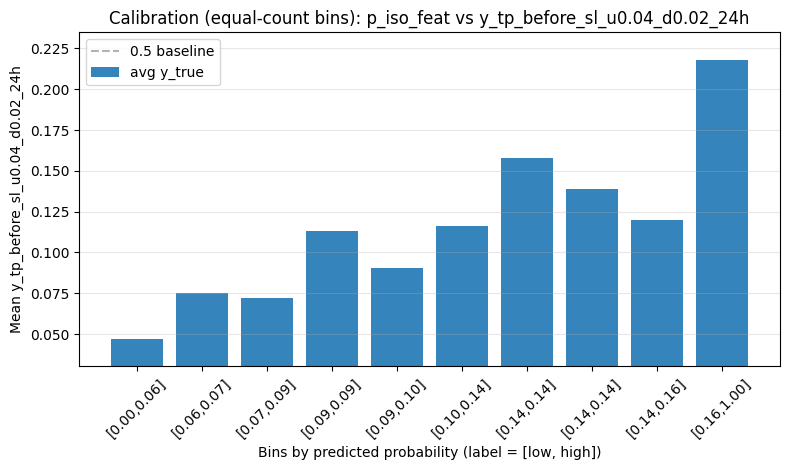

,bin,mean_p,mean_y,n,p_low,p_high
0,0,0.050560,0.047293,1755,1.000000e-12,0.059659
1,1,0.074441,0.075257,1754,5.965909e-02,0.074868
2,2,0.079309,0.072365,1755,7.486847e-02,0.093874
3,3,0.093874,0.113455,1754,9.387408e-02,0.093874
4,4,0.094594,0.090650,1754,9.387408e-02,0.097097
5,5,0.123699,0.116239,1755,9.709710e-02,0.140014
6,6,0.140014,0.157925,1754,1.400142e-01,0.140014
7,7,0.140014,0.139031,1755,1.400142e-01,0.140014
8,8,0.148099,0.119726,1754,1.400142e-01,0.164213
9,9,0.205115,0.217788,1754,1.642129e-01,1.000000


In [11]:
cal_table = plot_calibration_bins(dfc, prob_col='p_iso_feat', y_col='y_tp_before_sl_u0.04_d0.02_24h')
display(cal_table)

In [12]:
# Summarize short trade results
TH_SHORT = 0.06       # example short threshold
PROB_COL = 'p_iso_feat'  # which calibrated prob to use ('p_iso_feat' or 'p_platt_feat')

# Require dfc from the calibrator-fitting cell
if 'dfc' not in globals():
    raise SystemExit('dfc not found. Run the calibrator fitting cell to create dfc with calibrated probs.')

# Run simulation with only short threshold; long threshold irrelevant (set to +inf)
sim = simulate_trades(dfc, long_threshold=float('inf'), short_threshold=TH_SHORT, prob_col=PROB_COL)

import numpy as np
import pandas as pd
TB_LABEL_COL = 'y_tb_label_u0.04_d0.02_24h'
LOGRET_COL = 'y_logret_24h'

smask = sim['enter_short']
tb = pd.to_numeric(sim[TB_LABEL_COL], errors='coerce')
logret = pd.to_numeric(sim[LOGRET_COL], errors='coerce')
nat_mask_s = smask & (tb == 0)

n_rows = int(len(sim))
n_short = int(smask.sum())
# For shorts: -2% target corresponds to lower barrier hit first (tb == -1)
n_short_hit_neg2 = int((smask & (tb == -1)).sum())
# For shorts: +4% target corresponds to upper barrier hit first (tb == +1)
n_short_hit_pos4 = int((smask & (tb == 1)).sum())
n_short_nat = int(nat_mask_s.sum())

# Average natural close return for short trades: negative of expm1(logret)
nat_pct_ret_short = -np.expm1(logret[nat_mask_s].dropna())
avg_nat_ret_short = float(nat_pct_ret_short.mean()) if len(nat_pct_ret_short) > 0 else None

summary_short = {
  'prob_col': PROB_COL,
  'short_threshold': TH_SHORT,
  'n_rows': n_rows,
  'n_short': n_short,
  'n_short_hit_-2pct': n_short_hit_neg2,
  'n_short_hit_+4pct': n_short_hit_pos4,
  'n_short_natural': n_short_nat,
  'avg_nat_return_short': avg_nat_ret_short,
}
print(summary_short)
# Show a small sample of executed short trades
display(sim.loc[smask, ['timestamp', PROB_COL, TB_LABEL_COL, LOGRET_COL, 'ret_short']].head())


{'prob_col': 'p_iso_feat', 'short_threshold': 0.06, 'n_rows': 17544, 'n_short': 1793, 'n_short_hit_-2pct': 345, 'n_short_hit_+4pct': 91, 'n_short_natural': 1357, 'avg_nat_return_short': -0.002236446204154973}


,timestamp,p_iso_feat,y_tb_label_u0.04_d0.02_24h,y_logret_24h,ret_short
28907,2023-05-20 11:00:00,0.050633,0.0,-0.001881,0.001880
28908,2023-05-20 12:00:00,0.050633,0.0,0.001275,-0.001276
28909,2023-05-20 13:00:00,0.050633,0.0,0.000048,-0.000048
28910,2023-05-20 14:00:00,0.050633,0.0,-0.000669,0.000669
28911,2023-05-20 15:00:00,0.050633,0.0,-0.001895,0.001893


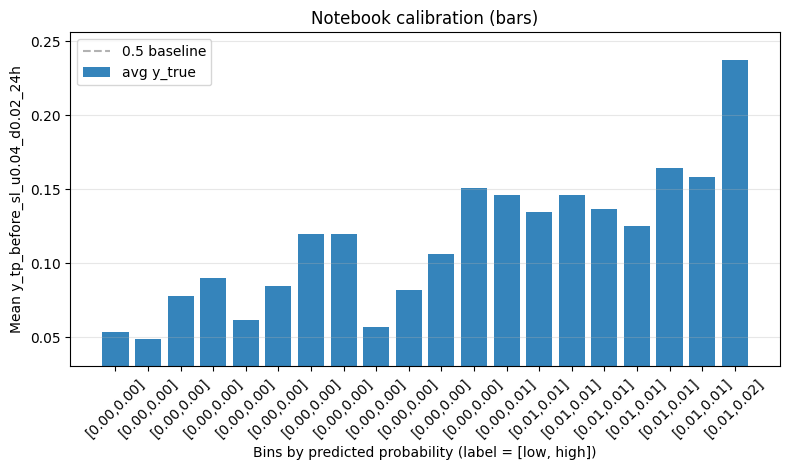

,bin,mean_p_x,mean_y_lib,n_lib,p_low_x,p_high_x,mean_p_y,mean_y_nb,n_nb,p_low_y,p_high_y,delta_mean_y
0,0,0.001410,0.053531,878,0.000486,0.001832,0.001410,0.053531,878,0.000486,0.001832,0.0
1,1,0.002078,0.049031,877,0.001832,0.002301,0.002078,0.049031,877,0.001832,0.002301,0.0
2,2,0.002510,0.077537,877,0.002301,0.002700,0.002510,0.077537,877,0.002301,0.002700,0.0
3,3,0.002879,0.090080,877,0.002701,0.003047,0.002879,0.090080,877,0.002701,0.003047,0.0
4,4,0.003193,0.061574,877,0.003047,0.003329,0.003193,0.061574,877,0.003047,0.003329,0.0
5,5,0.003463,0.084282,878,0.003329,0.003606,0.003463,0.084282,878,0.003329,0.003606,0.0
6,6,0.003728,0.119726,877,0.003606,0.003837,0.003728,0.119726,877,0.003606,0.003837,0.0
7,7,0.003936,0.119726,877,0.003838,0.004028,0.003936,0.119726,877,0.003838,0.004028,0.0
8,8,0.004130,0.057013,877,0.004029,0.004233,0.004130,0.057013,877,0.004029,0.004233,0.0
9,9,0.004352,0.082098,877,0.004234,0.004471,0.004352,0.082098,877,0.004234,0.004471,0.0


In [20]:
# Cross-check equal-count calibration table against notebook function (should match)
import sys
from pathlib import Path as _Path
for _cand in [_Path.cwd(), _Path.cwd().parent, _Path.cwd().parent.parent]:
    if (_cand / 'run' / 'binning.py').exists():
        if str(_cand) not in sys.path: sys.path.insert(0, str(_cand))
        break
from run.binning import equal_count_calibration

PROB_COL = 'close_parkinson_20_1H'   # or 'p_platt_feat'
Y_COL = 'y_tp_before_sl_u0.04_d0.02_24h'
N_BINS = 20

if 'dfc' not in globals():
    raise SystemExit('dfc not found. Run the calibrator fitting cell first to create dfc with calibrated probs.')

# Library rank-based equal-count calibration
cal_lib = equal_count_calibration(dfc[PROB_COL], dfc[Y_COL], n_bins=N_BINS, tie_breaker='first')
cal_lib = cal_lib.rename(columns={'mean_y':'mean_y_lib', 'n':'n_lib'})

# Notebook function (also rank-based equal-count in this notebook)
cal_nb = plot_calibration_bins(dfc, prob_col=PROB_COL, y_col=Y_COL, n_bins=N_BINS, title='Notebook calibration (bars)')
cal_nb = cal_nb.rename(columns={'mean_y':'mean_y_nb', 'n':'n_nb'})

# Join on integer bin index to avoid float-related join issues
cmp = cal_lib.merge(cal_nb[['bin','mean_p','mean_y_nb','n_nb','p_low','p_high']], on='bin', how='inner')
cmp['delta_mean_y'] = cmp['mean_y_lib'] - cmp['mean_y_nb']
display(cmp)


In [14]:
from pathlib import Path
import sys
import pandas as pd

# Locate repo root so we can import evaluator_simple
repo_root = Path.cwd().resolve()
while repo_root != repo_root.parent and not (repo_root / "evaluator_simple").exists():
    repo_root = repo_root.parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from evaluator_simple.simulate import simulate_ttl_lots
from evaluator_simple.report import summarize_lots


In [15]:
ohlcv_path = Path("/Volumes/Extreme SSD/trading_data/cex/training/binance_btcusdt_perp_1h_original/feature_store/ohlcv.csv")

ohlcv = pd.read_csv(ohlcv_path)
ohlcv.columns = [c.strip().lower() for c in ohlcv.columns]
# Normalize timestamp column: source file uses 'time' -> rename to 'timestamp'
if 'time' in ohlcv.columns and 'timestamp' not in ohlcv.columns:
    ohlcv = ohlcv.rename(columns={'time': 'timestamp'})

ohlcv["timestamp"] = pd.to_datetime(ohlcv["timestamp"], utc=True).dt.tz_convert("UTC").dt.tz_localize(None)
ohlcv = ohlcv.sort_values("timestamp").reset_index(drop=True)

required_cols = {"timestamp","open","high","low","close","volume"}
missing = required_cols - set(ohlcv.columns)
if missing:
    raise ValueError(f"Missing OHLCV columns: {missing}")
print(f"Loaded OHLCV: rows={len(ohlcv)}, cols={len(ohlcv.columns)}")


Loaded OHLCV: rows=49680, cols=6


In [16]:
# Use feature dataset (already loaded in notebook) as the signal source
# Expects a DataFrame named one of: features, features_df, df_features, df_feat
import pandas as pd

_feat = None
for _name in ("features", "features_df", "df_features", "df_feat", "feat"):
    if _name in globals():
        _obj = globals()[_name]
        if isinstance(_obj, pd.DataFrame):
            _feat = _obj
            break

if _feat is None:
    raise NameError("No features DataFrame found in variables: features, features_df, df_features, df_feat. Set one before running.")

# Ensure a timestamp column exists
if 'timestamp' not in _feat.columns:
    if isinstance(_feat.index, pd.DatetimeIndex):
        _feat = _feat.reset_index().rename(columns={'index': 'timestamp'})
    else:
        raise KeyError("Features DataFrame must have a 'timestamp' column or DatetimeIndex.")

# Pick the requested feature column as signal
_signal_col = 'close_parkinson_20_1H'
if _signal_col not in _feat.columns:
    # Attempt case-insensitive match
    _matches = [c for c in _feat.columns if str(c).lower() == _signal_col.lower()]
    if _matches:
        _signal_col = _matches[0]
    else:
        raise KeyError(f"Column '{_signal_col}' not found in features DataFrame.")

signals = _feat.loc[:, ['timestamp', _signal_col]].rename(columns={_signal_col: 'signal'}).copy()
# Normalize timestamps
signals['timestamp'] = pd.to_datetime(signals['timestamp'], utc=True).dt.tz_convert('UTC').dt.tz_localize(None)
signals = signals.sort_values('timestamp').reset_index(drop=True)
print("Signals set from features:", _signal_col, "rows=", len(signals))


Signals set from features: close_parkinson_20_1H rows= 49680


In [28]:
# Mock config (revise as you like)
config = {
    "entry": {
        "long": "signal > 0.01",
        "short": "signal < 0",
    },
    "sizing": {"lot_notional": 10000},
    "exec": {"exit_at": "next_open"},  # boundary for non-TP/SL exits
    "exit": {
        #"stops": {"stop_loss_pct": 0.02, "take_profit_pct": 0.04},
        # Optional time cap (uncomment to use):
        "hold_bars": 24,
    },
    # Optional time window (comment out to run full range)
    "window": {
        "start": "2023-05-01",
        "end": "2025-05-01",
    },
    "allow_both_sides": False,
}

lots = simulate_ttl_lots(ohlcv, signals, config)
summary = summarize_lots(lots)

print(f"Lots generated: {len(lots)}")
try:
    from IPython.display import display
    display(lots.head(20))
except Exception:
    print(lots.head(20))

print("Exit reason counts:")
print(lots["exit_reason"].value_counts(dropna=False))

print("\nSummary:")
for k, v in summary.items():
    print(f"  {k}: {v}")

Lots generated: 843


,enter_decision_ts,entry_ts,exit_decision_ts,exit_ts,exit_at,exit_reason,side,lot_notional,px_entry,px_exit,gross_return,pnl_trade,tp_pct,sl_pct,hold_bars,bars_held
0,2023-08-17 21:00:00,2023-08-17 22:00:00,2023-08-18 21:00:00,2023-08-18 22:00:00,next_open,TIME,1,10000.0,26250.0,26050.2,-0.007611,-76.114286,NaN,NaN,24,24
1,2023-08-17 22:00:00,2023-08-17 23:00:00,2023-08-18 22:00:00,2023-08-18 23:00:00,next_open,TIME,1,10000.0,26790.0,26055.1,-0.027432,-274.318776,NaN,NaN,24,24
2,2023-08-17 23:00:00,2023-08-18 00:00:00,2023-08-18 23:00:00,2023-08-19 00:00:00,next_open,TIME,1,10000.0,26609.7,26042.0,-0.021334,-213.343255,NaN,NaN,24,24
3,2023-08-18 00:00:00,2023-08-18 01:00:00,2023-08-19 00:00:00,2023-08-19 01:00:00,next_open,TIME,1,10000.0,26723.3,26087.2,-0.023803,-238.031980,NaN,NaN,24,24
4,2023-08-18 01:00:00,2023-08-18 02:00:00,2023-08-19 01:00:00,2023-08-19 02:00:00,next_open,TIME,1,10000.0,26602.7,26001.1,-0.022614,-226.142459,NaN,NaN,24,24
5,2023-08-18 02:00:00,2023-08-18 03:00:00,2023-08-19 02:00:00,2023-08-19 03:00:00,next_open,TIME,1,10000.0,26470.6,25987.3,-0.018258,-182.579919,NaN,NaN,24,24
6,2023-08-18 03:00:00,2023-08-18 04:00:00,2023-08-19 03:00:00,2023-08-19 04:00:00,next_open,TIME,1,10000.0,26386.0,25958.6,-0.016198,-161.979838,NaN,NaN,24,24
7,2023-08-18 04:00:00,2023-08-18 05:00:00,2023-08-19 04:00:00,2023-08-19 05:00:00,next_open,TIME,1,10000.0,26256.5,25976.8,-0.010653,-106.526003,NaN,NaN,24,24
8,2023-08-18 05:00:00,2023-08-18 06:00:00,2023-08-19 05:00:00,2023-08-19 06:00:00,next_open,TIME,1,10000.0,26427.7,25872.6,-0.021004,-210.044764,NaN,NaN,24,24
9,2023-08-18 06:00:00,2023-08-18 07:00:00,2023-08-19 06:00:00,2023-08-19 07:00:00,next_open,TIME,1,10000.0,26489.4,25823.9,-0.025123,-251.232568,NaN,NaN,24,24


Exit reason counts:
exit_reason
TIME    843
Name: count, dtype: int64

Summary:
  n_lots: 843
  n_long: 843
  n_short: 0
  total_trade_bars: 17545
  tp_rate_long: 0.0
  tp_rate_short: 0.0
  sl_rate_long: 0.0
  sl_rate_short: 0.0
  time_rate_long: 1.0
  time_rate_short: 0.0
  hit_rate_long: 0.6298932384341637
  hit_rate_short: 0.0
  mean_return_long: 0.007598168573884589
  mean_return_short: 0.0
  median_return_long: 0.010460439949711908
  median_return_short: 0.0
  p25_return_long: -0.010300622680721072
  p25_return_short: 0.0
  p75_return_long: 0.02801524887196516
  p75_return_short: 0.0
  mean_pnl_long: 75.9816857388459
  mean_pnl_short: 0.0
  total_pnl_long: 64052.561077847095
  total_pnl_short: 0.0
  avg_return_tp_long: 0.0
  avg_return_tp_short: 0.0
  avg_return_sl_long: 0.0
  avg_return_sl_short: 0.0
  avg_return_time_long: 0.007598168573884589
  avg_return_time_short: 0.0


In [18]:
lots

,enter_decision_ts,entry_ts,exit_decision_ts,exit_ts,exit_at,exit_reason,side,lot_notional,px_entry,px_exit,gross_return,pnl_trade,tp_pct,sl_pct,hold_bars,bars_held
0,2023-05-20 11:00:00,2023-05-20 12:00:00,2023-05-21 11:00:00,2023-05-21 12:00:00,next_open,TIME,-1,10000.0,26868.5,26818.000,-0.001880,18.795244,0.04,0.02,24,24
1,2023-05-20 12:00:00,2023-05-20 13:00:00,2023-05-21 12:00:00,2023-05-21 13:00:00,next_open,TIME,-1,10000.0,26882.9,26917.200,0.001276,-12.759040,0.04,0.02,24,24
2,2023-05-20 13:00:00,2023-05-20 14:00:00,2023-05-21 13:00:00,2023-05-21 14:00:00,next_open,TIME,-1,10000.0,26878.9,26880.100,0.000045,-0.446447,0.04,0.02,24,24
3,2023-05-20 14:00:00,2023-05-20 15:00:00,2023-05-21 14:00:00,2023-05-21 15:00:00,next_open,TIME,-1,10000.0,26906.0,26887.900,-0.000673,6.727124,0.04,0.02,24,24
4,2023-05-20 15:00:00,2023-05-20 16:00:00,2023-05-21 15:00:00,2023-05-21 16:00:00,next_open,TIME,-1,10000.0,26936.0,26885.100,-0.001890,18.896644,0.04,0.02,24,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2311,2025-04-27 00:00:00,2025-04-27 01:00:00,2025-04-28 00:00:00,2025-04-28 01:00:00,next_open,TIME,-1,10000.0,94825.3,93373.700,-0.015308,153.081509,0.04,0.02,24,24
2312,2025-04-27 21:00:00,2025-04-27 22:00:00,2025-04-28 21:00:00,2025-04-28 22:00:00,next_open,TIME,-1,10000.0,94289.3,94498.900,0.002223,-22.229458,0.04,0.02,24,24
2313,2025-04-27 22:00:00,2025-04-27 23:00:00,2025-04-28 22:00:00,2025-04-28 23:00:00,next_open,TIME,-1,10000.0,93890.5,94775.600,0.009427,-94.269388,0.04,0.02,24,24
2314,2025-04-27 23:00:00,2025-04-28 00:00:00,2025-04-28 12:00:00,2025-04-28 12:00:00,threshold,SL,-1,10000.0,93697.0,95570.940,0.020000,-200.000000,0.04,0.02,24,13
